# Draw tree with tips having plots with enrichments of each mutation type

The following cell is tagged parameters, and will be replaced by the [papermill](https://papermill.readthedocs.io/en/latest/) parameters when the notebook is actually run:

In [1]:
treefile = "../results/clade_founder_tree/clade_founders.treefile"
rates_by_clade_csv = "../results/synonymous_mut_rates/rates_by_clade.csv"
tree_image = "../results/clade_founder_tree/tree_w_enrichments.png"

Import Python modules:

In [2]:
import os

import ete3

import matplotlib
import matplotlib.pyplot as plt

import numpy

import yaml

import pandas as pd

/Users/jbloom/miniconda3/envs/ete3/lib/python3.9/site-packages/ete3-3.1.2-py3.7.egg/ete3/evol/parser/codemlparser.py:221: SyntaxWarning: "is" with a literal. Did you mean "=="?
/Users/jbloom/miniconda3/envs/ete3/lib/python3.9/site-packages/ete3-3.1.2-py3.7.egg/ete3/evol/parser/codemlparser.py:221: SyntaxWarning: "is" with a literal. Did you mean "=="?


Read some information from configuration:

In [3]:
with open("config.yaml" if os.path.isfile("config.yaml") else "../config.yaml") as f:
    config = yaml.safe_load(f)
    
clade_synonyms = config["clade_synonyms"]

Read the rates by clade, and also get list of all clades we are using:

In [4]:
rates_by_clade = pd.read_csv(rates_by_clade_csv)

clades = sorted(rates_by_clade["clade"].unique())

Read the tree and do some formatting:

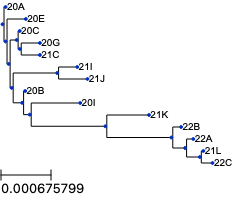

In [5]:
# read tree
with open(treefile) as f:
    newick_str = f.read()
t = ete3.Tree(newick_str)

# prune clades without rates
t.prune(clades, preserve_branch_length=True)

# set outgroup to first clade listed
t.set_outgroup(clades[0])

# ladderize the branches
t.ladderize()

t.render("%%inline")

Plot clade enrichments and save to images we can incorporate in tree:

In [6]:
rates_fold_change = (
    rates_by_clade
    [["clade", "mut_type", "rate"]]
    .merge(
        rates_by_clade
        .query("clade == @clades[0]")
        [["mut_type", "rate"]]
        .rename(columns={"rate": "ref_rate"})
    )
    .assign(diff_rate=lambda x: x["rate"] - x["ref_rate"])
)

# colors
viridis = matplotlib.cm.get_cmap("viridis", len(clades))
clade_colors = {
    clade: viridis(clades.index(clade) / (len(clades) - 1))
    for clade in clades
}

output_dir = os.path.join(os.path.dirname(tree_image), "enrichment_plots")
os.makedirs(output_dir, exist_ok=True)

clade_images = {}

for clade, clade_fold_change in rates_fold_change.groupby("clade"):
    ax = clade_fold_change.plot(
        x="mut_type",
        y="diff_rate",
        kind="bar",
        legend=False,
        figsize=(3, 0.8),
        xticks=[],
        yticks=[],
        xlabel="",
        ylim=(
            rates_fold_change["diff_rate"].min(), rates_fold_change["diff_rate"].max(),
        ),
        width=0.8,
        color=clade_colors[clade],
    )
    ax.spines["bottom"].set_position("zero")
    ax.spines["bottom"].set_color("gray")
    ax.spines["bottom"].set_linewidth(1)
    ax.spines["top"].set_color("none")
    ax.spines["right"].set_color("none")
    ax.spines["left"].set_color("none")
    ax.set_title(
        f"{clade} ({clade_synonyms[clade]})",
        fontdict={
        #    "color": clade_colors[clade],
            "fontweight": "bold",
        },
        loc="left",
    )
    
    fig = ax.get_figure()
    fig.set_linewidth(3)
    
    plotfile = os.path.join(output_dir, f"{clade}.png")
    print(f"Writing plot for {clade} to {plotfile}")
    fig.savefig(plotfile, dpi=720, bbox_inches="tight", edgecolor=clade_colors[clade])
    clade_images[clade] = plotfile
    
    plt.close()

Writing plot for 20A to ../results/clade_founder_tree/enrichment_plots/20A.png
Writing plot for 20B to ../results/clade_founder_tree/enrichment_plots/20B.png
Writing plot for 20C to ../results/clade_founder_tree/enrichment_plots/20C.png
Writing plot for 20E to ../results/clade_founder_tree/enrichment_plots/20E.png
Writing plot for 20G to ../results/clade_founder_tree/enrichment_plots/20G.png
Writing plot for 20I to ../results/clade_founder_tree/enrichment_plots/20I.png
Writing plot for 21C to ../results/clade_founder_tree/enrichment_plots/21C.png
Writing plot for 21I to ../results/clade_founder_tree/enrichment_plots/21I.png
Writing plot for 21J to ../results/clade_founder_tree/enrichment_plots/21J.png
Writing plot for 21K to ../results/clade_founder_tree/enrichment_plots/21K.png
Writing plot for 21L to ../results/clade_founder_tree/enrichment_plots/21L.png
Writing plot for 22A to ../results/clade_founder_tree/enrichment_plots/22A.png
Writing plot for 22B to ../results/clade_founder_tre

Now create a layout function:

In [7]:
clade_img_height = 500

def clade_image_layout(node):
    ns = ete3.NodeStyle()
    ns["hz_line_width"] = ns["vt_line_width"] = 0.04 * clade_img_height
    node.set_style(ns)
    if node.is_leaf():
        ete3.faces.add_face_to_node(
            ete3.faces.ImgFace(clade_images[node.name], height=clade_img_height),
            node,
            column=0,
        )
        node.img_style["size"] = clade_img_height / 8
        node.img_style["fgcolor"] = matplotlib.colors.rgb2hex(
            clade_colors[node.name]
        )
    else:
        node.img_style["size"] = 0
        
ts = ete3.TreeStyle()
ts.show_leaf_name = False
ts.layout_fn = clade_image_layout
ts.scale = 1750 * clade_img_height
ts.branch_vertical_margin = 0.05 * clade_img_height
ts.margin_left = ts.margin_right = ts.margin_top = 0.05 * clade_img_height
ts.scale_length = 0.001

_ = t.render(
    tree_image,
    tree_style=ts,
    dpi=1440,
    h=clade_img_height * len(clades) * 1.1,
)